In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [59]:
class Arm:
    def __init__(self, p):
        self.p = p

    def pull(self):
        return np.random.binomial(1, self.p)

class MultiBandit:
    def __init__(self, probs = [0.1, 0.2, 0.7, 0.5]):
        self.__arms = [Arm(p) for p in probs]
        self.__regret = 0
        self.__maxp = max(probs)

    def num_arms(self):
        return len(self.__arms)

    def pull(self, arm_num):
        reward = self.__arms[arm_num].pull()
        self.__regret += self.__maxp-self.__arms[arm_num].p
        return reward

    def regret(self):
        return self.__regret


In [60]:
class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.epsilon = epsilon
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        # Return the arm with the highest average reward
        avg_rewards = self.arm_rewards / (self.arm_pulls + 1e-8)
        return int(np.argmax(avg_rewards))

    def select_arm(self):
        # Epsilon-Greedy logic: explore vs exploit
        if random.random() < self.epsilon:
            return random.randint(0, self.num_arms - 1)
        else:
            avg_rewards = self.arm_rewards / (self.arm_pulls + 1e-8)
            return int(np.argmax(avg_rewards))

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            self.arm_pulls[arm_to_pull] += 1
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1
            self.regrets[t] = bandit.regret()

    def plot(self):
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(self.horizon), self.regrets, label=f"Epsilon = {self.epsilon}")
        plt.xlabel("Timesteps")
        plt.ylabel("Total Regret")
        plt.title("Epsilon-Greedy: Regret vs Time")
        plt.legend()
        plt.grid(True)
        plt.show()


Total Regret after 100 timesteps: 17.3 with assumed best arm 2


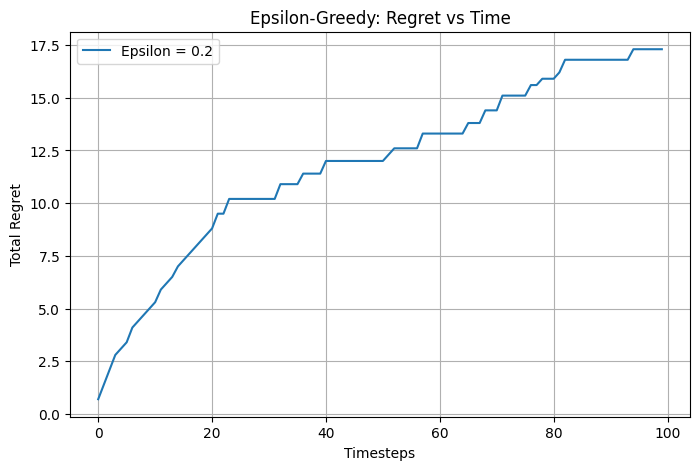

In [61]:
# Define a MultiBandit instance
bandit = MultiBandit([0.1, 0.3, 0.8, 0.5, 0.2])

# Set the horizon size
H = 100

# Create Epsilon-Greedy Algorithm instance
algorithm = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=H, epsilon=0.2)

# Run the algorithm
algorithm.run_algorithm(bandit)

# Display total regret and predicted best arm
print(f"Total Regret after {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")

# Plot the regret over time
algorithm.plot()


Total Regret after 100 timesteps: 29.59999999999994 with assumed best arm 3


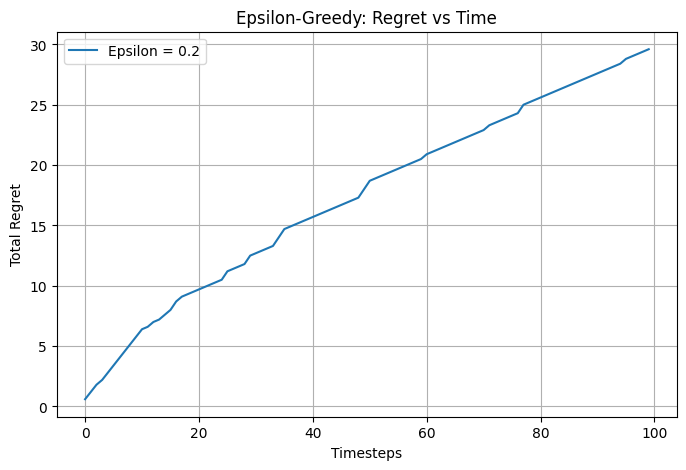

In [62]:
# Define a MultiBandit instance
bandit = MultiBandit([0.2, 0.4, 0.8, 0.6, 0.1])  #changed list

# Set the horizon size
H = 100

# Create Epsilon-Greedy Algorithm instance
algorithm = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=H, epsilon=0.2)

# Run the algorithm
algorithm.run_algorithm(bandit)

# Display total regret and predicted best arm
print(f"Total Regret after {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")

# Plot the regret over time
algorithm.plot()


In [63]:
import math
class UCB1Algorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        avg_rewards = self.arm_rewards / np.maximum(self.arm_pulls, 1)
        return int(np.argmax(avg_rewards))

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.arm_pulls[arm] == 0:
                return arm  # Play each arm once

        ucb_values = np.zeros(self.num_arms)
        total_pulls = np.sum(self.arm_pulls)

        for arm in range(self.num_arms):
            avg_reward = self.arm_rewards[arm] / self.arm_pulls[arm]
            confidence = math.sqrt((2 * math.log(total_pulls)) / self.arm_pulls[arm])
            ucb_values[arm] = avg_reward + confidence

        return int(np.argmax(ucb_values))

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            self.arm_pulls[arm_to_pull] += 1
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1
            self.regrets[t] = bandit.regret()

    def plot(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(self.horizon), self.regrets, label="UCB1 Regret", color="blue")
        plt.xlabel("Timesteps")
        plt.ylabel("Cumulative Regret")
        plt.title("UCB1 Algorithm - Regret Over Time")
        plt.grid(True)
        plt.show()


Total Regret after 100 timesteps: 20.899999999999984 with assumed best arm 2


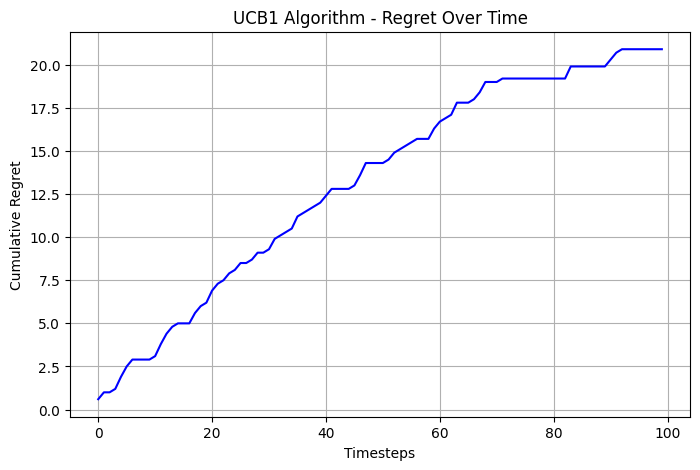

In [64]:
# Define bandit
bandit = MultiBandit([0.2, 0.4, 0.8, 0.6, 0.1])
H = 100

# Create UCB1 algorithm instance
ucb_algo = UCB1Algorithm(num_arms=bandit.num_arms(), horizon=H)

# Run the algorithm
ucb_algo.run_algorithm(bandit)

# Display total regret
print(f"Total Regret after {H} timesteps: {bandit.regret()} with assumed best arm {ucb_algo.give_best_arm()}")
ucb_algo.plot()


In [69]:
class ThompsonSamplingAlgorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0

        self.successes = np.ones(num_arms)  # alpha = 1 (prior)
        self.failures = np.ones(num_arms)   # beta = 1 (prior)

        self.arm_pulls = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        return np.argmax(self.successes / (self.successes + self.failures))

    def select_arm(self):
        sampled_probs = np.random.beta(self.successes, self.failures)
        return np.argmax(sampled_probs)

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)

            self.arm_pulls[arm_to_pull] += 1
            self.successes[arm_to_pull] += reward
            self.failures[arm_to_pull] += (1 - reward)

            self.timestep += 1
            self.regrets[t] = bandit.regret()

    def plot(self):
        plt.plot(range(self.horizon), self.regrets)
        plt.xlabel("Timestep")
        plt.ylabel("Total Regret")
        plt.title("Thompson Sampling - Total Regret vs Timesteps")
        plt.grid()
        plt.show()


Total Regret after 100 timesteps: 11.699999999999994 with assumed best arm 2


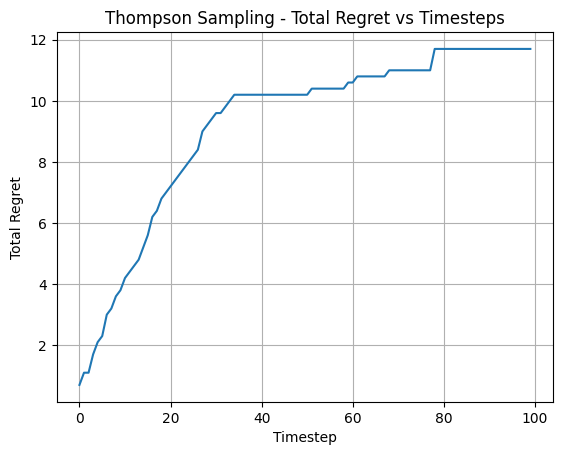

In [70]:
# Define bandit
bandit = MultiBandit([0.2, 0.4, 0.8, 0.6, 0.1])
H = 100

# Create algorithm instance
ts_algo = ThompsonSamplingAlgorithm(num_arms=bandit.num_arms(), horizon=H)

# Run algorithm
ts_algo.run_algorithm(bandit)

# Print results
print(f"Total Regret after {H} timesteps: {bandit.regret()} with assumed best arm {ts_algo.give_best_arm()}")
ts_algo.plot()


Epsilon-Greedy : Total Regret: 48.50000000000007 | Best Arm: 2
UCB1           : Total Regret: 55.300000000000146 | Best Arm: 2
Thompson       : Total Regret: 13.699999999999994 | Best Arm: 2


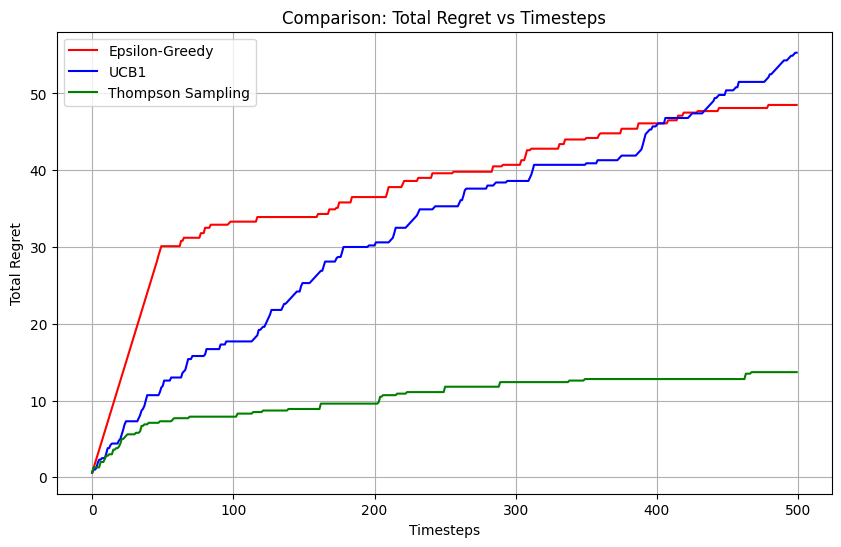

In [73]:
probs = [0.2, 0.4, 0.8, 0.6, 0.1]
H = 500

# Initialize and run Epsilon-Greedy
bandit1 = MultiBandit(probs)
eg_algo = EpsilonGreedyAlgorithm(num_arms=bandit1.num_arms(), horizon=H, epsilon=0.1)
eg_algo.run_algorithm(bandit1)

# Initialize and run UCB1
bandit2 = MultiBandit(probs)
ucb_algo = UCB1Algorithm(num_arms=bandit2.num_arms(), horizon=H)
ucb_algo.run_algorithm(bandit2)

# Initialize and run Thompson Sampling
bandit3 = MultiBandit(probs)
ts_algo = ThompsonSamplingAlgorithm(num_arms=bandit3.num_arms(), horizon=H)
ts_algo.run_algorithm(bandit3)

# Print results
print(f"Epsilon-Greedy : Total Regret: {bandit1.regret()} | Best Arm: {eg_algo.give_best_arm()}")
print(f"UCB1           : Total Regret: {bandit2.regret()} | Best Arm: {ucb_algo.give_best_arm()}")
print(f"Thompson       : Total Regret: {bandit3.regret()} | Best Arm: {ts_algo.give_best_arm()}")

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(eg_algo.regrets, label="Epsilon-Greedy", color='red')
plt.plot(ucb_algo.regrets, label="UCB1", color='blue')
plt.plot(ts_algo.regrets, label="Thompson Sampling", color='green')
plt.xlabel("Timesteps")
plt.ylabel("Total Regret")
plt.title("Comparison: Total Regret vs Timesteps")
plt.legend()
plt.grid(True)
plt.show()


Thompson Sampling performed best cause it has flatter curve means the algorithm quickly found the best arm and stuck with it.

